# Example: using a different force field

Here we show how to use MDPOW to calculate partition coefficients using an force field that isn't included in the package. To follow along, install `jupyter` in your `mdpow` environment.

To implement a new force field, you will need:

* `ITP` files for the molecule, the solvents, ions and also the general atom type definitions file (usually just named after the force field itself).
* `MDP` files for the energy minimisation, initial relaxation, NPT ensemble run and free energy calculation.
* Structure files (`.gro` or `.pdb`) for the solute and non-aqueous solvent. If you are using a type of water that does not come bundled with GROMACS, like in this example, you will also need to create an equilibrated box of pure water.

The first thing we'll do is to download the files we need for Martini 3.0.

In [1]:
from pathlib import Path
from typing import Optional

import requests as req


HERE = Path(".")
MARTINI_FF = HERE / "martini.ff"
MARTINI_FF.mkdir(exist_ok=True)

MARTINI_ITP = MARTINI_FF / "forcefield.itp"
MARTINI_IONS = MARTINI_FF / "martini_v3.0.0_ions_v1.itp"
MARTINI_SMALL_MOLS = MARTINI_FF / "martini_v3.0.0_small_molecules_v1.itp"
MARTINI_SOLVENTS = MARTINI_FF / "martini_v3.0.0_solvents_v1.itp"
BENZENE_ITP = MARTINI_SMALL_MOLS

MARTINI_WATER = HERE / "water.gro"
MARTINI_OCTANOL = HERE / "octanol.gro"
MARTINI_BENZENE = HERE / "benzene.pdb"

EM_FILE = HERE / "em.mdp"
EQ_FILE = HERE / "eq.mdp"
RUN_FILE = HERE / "run.mdp"


def download_file(
    url: str, out: Optional[Path] = None, chunk_size: int = 128, overwrite: bool = False
):
    """Utility function to download files."""
    if out is None:
        out = HERE / Path(url).name

    if out.exists() and not overwrite:
        return

    r = req.get(url, stream=True)
    r.raise_for_status()

    with out.open("wb") as f:
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)


DOWNLOADS = {
    MARTINI_ITP: "https://raw.githubusercontent.com/marrink-lab/martini-forcefields/main/martini_forcefields/regular/v3.0.0/gmx_files/martini_v3.0.0.itp",
    MARTINI_IONS: "https://raw.githubusercontent.com/marrink-lab/martini-forcefields/main/martini_forcefields/regular/v3.0.0/gmx_files/martini_v3.0.0_ions_v1.itp",
    MARTINI_SMALL_MOLS: "https://raw.githubusercontent.com/marrink-lab/martini-forcefields/main/martini_forcefields/regular/v3.0.0/gmx_files/martini_v3.0.0_small_molecules_v1.itp",
    MARTINI_SOLVENTS: "https://raw.githubusercontent.com/marrink-lab/martini-forcefields/main/martini_forcefields/regular/v3.0.0/gmx_files/martini_v3.0.0_solvents_v1.itp",
}

for fname, url in DOWNLOADS.items():
    download_file(url, fname)

This should have downloaded several files to your workspace.

We also need to make a `watermodels.dat` file in the `martini.ff` subdirectory.


In [2]:
WATERMODEL_DAT = MARTINI_FF / "watermodels.dat"

WATERMODEL_DAT.write_text("martini-water\tMARTINI-WATER\tMartini default water model.")

56

Next, we set up the files for the Martini 3.0 forcefield.

In [3]:
from mdpow.forcefields import Forcefield, GromacsSolventModel

MARTINI = Forcefield(
    "Martini",
    solvent_models={
        "octanol": GromacsSolventModel(
            identifier="octanol",
            itp=MARTINI_SOLVENTS.absolute(),
            coordinates=str(MARTINI_OCTANOL.absolute()),
            forcefield="Martini",
        ),
    },
    forcefield_dir=MARTINI_FF.absolute(),
    ions_itp=MARTINI_IONS.absolute(),
    default_water_itp=MARTINI_SOLVENTS.absolute(),
    default_water_model="martini-water",
    water_models={
        "martini-water": GromacsSolventModel(
            identifier="martini-water",
            itp=MARTINI_SOLVENTS.absolute(),
            coordinates=str(MARTINI_WATER.absolute()),
            forcefield="Martini",
        ),
    },
)

mdpow       : INFO     MDPOW 0+untagged.603.ge92ffd8.dirty starting.
mdpow       : INFO     Copyright (c) 2010-2023 Shujie Fan, Ian Kenney, Alia Lescoulie, Cade Duckworth, Bogdan Iorga, and Oliver Beckstein
mdpow       : INFO     Released under the GNU Public Licence, version 3.
mdpow       : INFO     For bug reports and help: https://github.com/Becksteinlab/MDPOW/issues
mdpow.config: INFO     Using the bundled force fields from GMXLIB='/home/awsm/MDPOW/mdpow/top'.
mdpow.config: INFO     If required, override this behaviour by setting the environment variable GMXLIB yourself.


In [4]:
from dataclasses import asdict

for solvent_name, solvent_model in MARTINI.solvent_models.items():
    print(solvent_name)
    print(asdict(solvent_model))

octanol
{'identifier': 'octanol', 'name': 'OCTANOL', 'itp': PosixPath('/home/awsm/MDPOW/doc/examples/martini/martini.ff/martini_v3.0.0_solvents_v1.itp'), 'coordinates': '/home/awsm/MDPOW/doc/examples/martini/octanol.gro', 'description': None, 'forcefield': 'Martini'}


In [5]:
from mdpow.equil import WaterSimulation

sim = WaterSimulation(
    molecule="BENZ",
    ff_class=MARTINI,
    mdp={
        "energy_minimize": str(EM_FILE.absolute()),
        "MD_relaxed": str(EQ_FILE.absolute()),
        "MD_NPT": str(EQ_FILE.absolute()),
        "MD_restrained": str(RUN_FILE.absolute()),
    },
    distance=3.0,
)
sim.topology(str(BENZENE_ITP))
sim.solvate(struct=MARTINI_BENZENE, maxwarn=1)
sim.energy_minimize(maxwarn=1)
sim.MD_relaxed(runtime=1e3, dt=0.01)

gromacs.utilities: INFO     Working in '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top' (newly created)...
mdpow.equil : INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top] Created topology 'system.top' that includes 'martini_v3.0.0_small_molecules_v1.itp'
gromacs.utilities: INFO     Working in '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation' (newly created)...
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation] Solvating with water '/home/awsm/MDPOW/doc/examples/martini/water.gro'...
                     :-) GROMACS - gmx editconf, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation
Command line:
  gmx editconf -f /home/awsm/MDPOW/doc/examples/martini/benzene.pdb -o boxed.gro -bt dodecahedron -d 3.0


GROMACS reminds you: "According to my computations we're overdue for a transformati

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 3 atoms
Volume: 4050 nm^3, corresponds to roughly 1822500 electrons
No velocities found
    system size :  0.210  0.160  0.248 (nm)
    diameter    :  0.270               (nm)
    center      :  2.987  0.606  2.315 (nm)
    box vectors : 15.000 15.000 18.000 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :4050.00               (nm^3)
    shift       :  1.716  4.097 -0.098 (nm)
new center      :  4.703  4.703  2.217 (nm)
new box vectors :  6.270  6.270  6.270 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  : 174.32               (nm^3)

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functiona

gromacs.cbook: INFO     system total charge qtot = 0
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation] After solvation: total charge qtot = 0 = 0
gromacs.cbook: INFO     system total charge qtot = 0
gromacs.setup: INFO     Building the main index file 'main.ndx'...
                     :-) GROMACS - gmx make_ndx, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation
Command line:
  gmx make_ndx -f ionized.tpr -o main.ndx


Reading structure file
Reading file ionized.tpr, VERSION 2023.2 (single precision)
Reading file ionized.tpr, VERSION 2023.2 (single precision)

GROMACS reminds you: "Expertise is not inherently good." (Joe Jordan)

                     :-) GROMACS - gmx make_ndx, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Selected 4: '__main__'
Select group for output
Selected 0: 'System'


atom name 638 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 639 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 640 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 641 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 642 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 643 i

Setting the LD random seed to -1526990921

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

atom name 638 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 639 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 640 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 641 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom 

atom name 638 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 639 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 640 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 641 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 642 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 643 i

Setting the LD random seed to 2013264681

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

atom name 638 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 639 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 640 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom name 641 in /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top and /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/solvated.gro does not match (W - W 1)

atom n

Reading file em.tpr, VERSION 2023.2 (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 4 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+01
   Number of steps    =         1000
Step=    0, Dmax= 1.0e-02 nm, Epot=  9.59019e+06 Fmax= 1.69656e+07, atom= 149
Step=    1, Dmax= 1.0e-02 nm, Epot=  6.21902e+06 Fmax= 6.01139e+06, atom= 478
Step=    2, Dmax= 1.2e-02 nm, Epot=  3.58839e+06 Fmax= 2.70774e+06, atom= 17
Step=    3, Dmax= 1.4e-02 nm, Epot=  2.18086e+06 Fmax= 1.08770e+06, atom= 1305
Step=    4, Dmax= 1.7e-02 nm, Epot=  1.25600e+06 Fmax= 5.29430e+05, atom= 1493
Step=    5, Dmax= 2.1e-02 nm, Epot=  7.79933e+05 Fmax= 2.60389e+05, atom= 1513
Step=    6, Dmax= 2.5e-02 nm, Epot=  4.76315e+05 Fmax= 1.79135e+05, atom= 1493
Step=    7, Dmax= 3.0e-02 nm, 

Setting the LD random seed to -2343429

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.132 nm, buffer size 0.032 nm

Set rlist, assuming 4x4 atom pair-list, to 1.108 nm, buffer size 0.008 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 1 Mb of data


{'struct': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_relaxed/md.gro',
 'top': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/system.top',
 'ndx': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx',
 'qscript': ['./local.sh'],
 'mainselection': None,
 'deffnm': 'md',
 'includes': ['/home/awsm/MDPOW/mdpow/top',
  '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top']}

In [6]:
import gromacs

r = gromacs.run.MDrunner(
    dirname=sim.dirs["MD_relaxed"],
    deffnm="md",
    c="md.pdb",
    cpi=True,
    v=True,
)
r.run()  # runs mdrun in the python shell

gromacs.run : INFO     gmx mdrun -deffnm md -c md.pdb -cpi -v
                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_relaxed
Command line:
  gmx mdrun -deffnm md -c md.pdb -cpi -v

Reading file md.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 10 to 50, rlist from 1.108 to 1.274

1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
Using 1 MPI thread
Using 4 OpenMP threads 

starting mdrun 'Compound BENZ in water'
100000 steps,   1000.0 ps.

Step 0  Warning: pressure scaling more than 1%, mu: 0.98589 0.98589 0.98589
step 0
Step 50  Warning: pressure scaling more than 1%, mu: 1.02318 1.02318 1.02318
step 100, remaining wall clock time:    39 s          

0

In [7]:
sim.MD(
    runtime=1e4, qscript=["local.sh"], dt=0.02
)

r = gromacs.run.MDrunner(
    dirname=sim.dirs["MD_NPT"], deffnm="md", c="md.pdb", cpi=True, v=True
)
r.run()  # runs mdrun in the python shell

mdpow.equil : INFO     Found starting structure '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_relaxed/md.pdb' (instead of '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_relaxed/md.gro').
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_NPT] Setting up MD...
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_NPT] input mdp  = '/home/awsm/MDPOW/doc/examples/martini/eq.mdp'
gromacs.utilities: INFO     Working in '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_NPT' (newly created)...
gromacs.cbook: INFO     editing mdp = '/home/awsm/MDPOW/doc/examples/martini/eq.mdp': dict_keys(['nsteps', 'dt', 'pp', 't', 'include'])
gromacs.cbook: WARNING  Not substituted in 'md.mdp': ['pp', 't']
gromacs.setup: WARNING  Unprocessed mdp option are interpreted as options for grompp:
{'pp': 'processed.top', 't': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_relaxed/md.cpt'}
/home/awsm/mamb

Setting the LD random seed to -100958209

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.175 nm, buffer size 0.075 nm

Set rlist, assuming 4x4 atom pair-list, to 1.133 nm, buffer size 0.033 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

Reading Coordinates, Velocities and Box size from old trajectory

Will read whole trajectory

Using frame at t = 1000 ps

Starting time for run is 0 ps

This run will generate roughly 6 Mb of data


Reading file md.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 10 to 25, rlist from 1.133 to 1.262

1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
Using 1 MPI thread
Using 4 OpenMP threads 

starting mdrun 'Compound BENZ in water'
500000 steps,  10000.0 ps.
step 499900, remaining wall clock time:     0 s          443700, remaining wall clock time:    26 s          493000, remaining wall clock time:     3 s          
Writing final coordinates.
step 500000, remaining wall clock time:     0 s          
               Core t (s)   Wall t (s)        (%)
       Time:      942.251      235.563      400.0
                 (ns/day)    (hour/ns)
Performance:     3667.817        0.007

GROMACS reminds you: "Inventions have long since reached their limit, and I see no hope for further development." (Julius

0

In [10]:
import mdpow.fep

gwat = mdpow.fep.Ghyd(simulation=sim, runtime=1e+3, mdp=str(RUN_FILE.absolute()))
gwat.setup(dt=0.02)

# run multiple simulations on cluster

mdpow.fep   : INFO     Found starting structure '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_NPT/md.pdb' (instead of '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/MD_NPT/md.gro').
/home/awsm/MDPOW/mdpow/fep.py:596: UserWarning: Directory 'FEP/water' already exists --- will overwrite existing files.
  warnings.warn(wmsg)
mdpow.fep   : WARNING  Directory 'FEP/water' already exists --- will overwrite existing files.
mdpow.fep   : INFO     Solvation free energy calculation for molecule BENZ in solvent water.
mdpow.fep   : INFO     Base directory is '/home/awsm/MDPOW/doc/examples/martini'
mdpow.fep   : INFO     Using setup directories under 'FEP/water': {'coulomb': 'FEP/water/Coulomb', 'vdw': 'FEP/water/VDW'}
mdpow.fep   : INFO     Default checkpoint file is '/home/awsm/MDPOW/doc/examples/martini/FEP/water/Ghyd.fep'
mdpow.fep   : INFO     Preparing coulomb for lambda=0
mdpow.fep   : INFO     Setting dhdl file to edr format
gromacs.setup: INFO     [/home/awsm/MDPOW/

Setting the LD random seed to -1276686385

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 2 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Not to get technical... but according to chemistry, alcohol is a solution." (Anonymous)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0250] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0250] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0250] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0250] output runscripts = ['./local

Setting the LD random seed to -313278573

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 2 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Not to get technical... but according to chemistry, alcohol is a solution." (Anonymous)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0500] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0500] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0500] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0500] output runscripts = ['./local

Setting the LD random seed to -18777225

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 2 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "In science, truth always wins." (Max Perutz)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0750] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0750] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0750] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0750] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/M

Setting the LD random seed to -1187233801

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 2 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Your Bones Got a Little Machine" (Pixies)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/1000] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/1000] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/1000] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/1000] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPO

Setting the LD random seed to 2062417135

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 2 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Your Bones Got a Little Machine" (Pixies)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0000] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0000] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0000] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0000] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/m

Setting the LD random seed to -1225019537

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Naive you are if you believe life favours those who aren't naive." (Piet Hein)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050] output runscripts = ['./local.sh']
gromacs.setup: INFO

Setting the LD random seed to 1203762038

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Naive you are if you believe life favours those who aren't naive." (Piet Hein)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0100] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0100] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0100] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0100] output runscripts = ['./local.sh']
gromacs.setup: INFO

Setting the LD random seed to -369033

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Shake Yourself" (YES)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0200] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0200] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0200] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0200] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW

Setting the LD random seed to 1973943263

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Shake Yourself" (YES)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW

Setting the LD random seed to -118815233

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Science, my lad, is made up of mistakes, but they are mistakes which it is useful to make, because they lead little by little to the truth." (Jules Verne)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0400] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0400] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0400] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martin

Setting the LD random seed to -1100921521

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "You Can Always Go On Ricky Lake" (Offspring)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0500] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0500] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0500] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0500] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/example

Setting the LD random seed to -1431325972

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "You Can Always Go On Ricky Lake" (Offspring)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/example

Setting the LD random seed to 522582511

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "As Always Your Logic Is Impeccable" (Tuvok)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0650] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0650] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0650] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0650] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples

Setting the LD random seed to -1291878529

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "As Always Your Logic Is Impeccable" (Tuvok)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0700] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0700] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0700] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0700] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples

Setting the LD random seed to 1568472927

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Science Won't Change You" (The Talking Heads)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/exampl

Setting the LD random seed to -35946561

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Computer system analysis is like child-rearing; you can do grievous damage, but you cannot ensure success." (Tom DeMarcho)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0800] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0800] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0800] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0800] output run

Setting the LD random seed to -17572231

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Computer system analysis is like child-rearing; you can do grievous damage, but you cannot ensure success." (Tom DeMarcho)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850] output run

Setting the LD random seed to 1806893055

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "The historical meaning of QM/MM: Quanto Mangi, Mamma Mia!" (Attilio Vittorio Vargiu, at BioExcel 2022 Summer School in Sardinia)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0900] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0900] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0900] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0900] outp

Setting the LD random seed to -1083769157

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "The historical meaning of QM/MM: Quanto Mangi, Mamma Mia!" (Attilio Vittorio Vargiu, at BioExcel 2022 Summer School in Sardinia)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0950] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0950] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0950] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0950] outp

Setting the LD random seed to -570441874

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


Number of degrees of freedom in T-Coupling group System is 4902.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Beware of bugs in the above code; I have only proved it correct, not tried it." (Donald Knuth)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000] output runscripts = ['./local.sh']
gro

Setting the LD random seed to -311828649

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'W'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.197 nm

Set rlist, assuming 4x4 atom pair-list, to 1.214 nm, buffer size 0.114 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


{'top': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/top/pp_system.top',
 'ndx': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/water/solvation/main.ndx',
 'qscript': ['./local.sh'],
 'mainselection': None,
 'deffnm': 'md',
 'includes': ['/home/awsm/MDPOW/mdpow/top'],
 'maxwarn': 1,
 'couple-intramol': 'no',
 'couple_lambda0': 'vdw',
 'couple_lambda1': 'none',
 'sc_alpha': 0.5,
 'sc_power': 1,
 'sc_sigma': 0.3,
 'separate-dhdl-file': 'no',
 'ref_t': 300.0,
 'gen_temp': 300.0,
 'free_energy': 'yes',
 'couple_moltype': 'BENZ',
 'init_lambda_state': 15,
 'fep_lambdas': array([0.  , 0.05, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.65, 0.7 , 0.75,
        0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 'calc_lambda_neighbors': -1}

In [11]:
for dir_ in gwat.fep_dirs():
    r = gromacs.run.MDrunner(
        dirname=dir_, deffnm="md", c="md.pdb", cpi=True, v=True, dhdl=True
    )
    r.run()  # runs mdrun in the python shell

gromacs.run : INFO     gmx mdrun -deffnm md -c md.pdb -cpi -v -dhdl
                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0000
Command line:
  gmx mdrun -deffnm md -c md.pdb -cpi -v -dhdl

Reading file md.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 20 to 25, rlist from 1.214 to 1.262

1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 4 OpenMP threads 

starting mdrun 'Compound BENZ in water'
50000 steps,   1000.0 ps.
step 49900, remaining wall clock time:     0 s          
Writing final coordinates.
step 50000, remaining wall clock time:     0 s          
               Core t (s)   Wall t (s)        (%)
       Time:      1

In [18]:
gwat.convert_edr()
gwat.analyze_alchemlyb()

mdpow.fep   : INFO     [FEP/water] Converting EDR -> XVG.bz2
mdpow.fep   : INFO       /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0000/md.edr --> /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0000/md.xvg
                      :-) GROMACS - gmx energy, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini
Command line:
  gmx energy -s /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0000/md.tpr -f /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0000/md.edr -odh /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0000/md.xvg

Opened /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0000/md.edr as single precision energy file
Reading file /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0000/md.tpr, VERSION 2023.2 (single precision)
Last energy frame read 250 time 1000.000          

GROMACS reminds you: "Nobody Never Learnt No-Nothing from No History" 



Wrote 8 lambda values with 5001 samples as 2008 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0000/md.xvg


Wrote 8 lambda values with 5001 samples as 2008 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0250/md.xvg


Wrote 8 lambda values with 5001 samples as 2008 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0500/md.xvg


Wrote 8 lambda values with 5001 samples as 2008 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/0750/md.xvg


Wrote 8 lambda values with 5001 samples as 2008 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/Coulomb/1000/md.xvg


Last energy frame read 250 time 1000.000          

GROMACS reminds you: "Nobody Never Learnt No-Nothing from No History" (Gogol Bordello)

mdpow.fep   : INFO       /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050/md.edr --> /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050/md.xvg
                      :-) GROMACS - gmx energy, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini
Command line:
  gmx energy -s /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050/md.tpr -f /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050/md.edr -odh /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050/md.xvg

Opened /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050/md.edr as single precision energy file
Reading file /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050/md.tpr, VERSION 2023.2 (single precision)
Last energy frame read 250 time 1000.000          

GROMACS reminds you



Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0000/md.xvg


Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0050/md.xvg


Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0100/md.xvg


Last energy frame read 250 time 1000.000          

GROMACS reminds you: "Nobody Never Learnt No-Nothing from No History" (Gogol Bordello)

mdpow.fep   : INFO       /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300/md.edr --> /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300/md.xvg
                      :-) GROMACS - gmx energy, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini
Command line:
  gmx energy -s /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300/md.tpr -f /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300/md.edr -odh /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300/md.xvg

Opened /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300/md.edr as single precision energy file
Reading file /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300/md.tpr, VERSION 2023.2 (single precision)
Last energy frame read 250 time 1000.000          

GROMACS reminds you



Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0200/md.xvg


Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0300/md.xvg


Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0400/md.xvg


Last energy frame read 250 time 1000.000         

GROMACS reminds you: "Nobody Never Learnt No-Nothing from No History" (Gogol Bordello)

mdpow.fep   : INFO       /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600/md.edr --> /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600/md.xvg
                      :-) GROMACS - gmx energy, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini
Command line:
  gmx energy -s /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600/md.tpr -f /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600/md.edr -odh /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600/md.xvg

Opened /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600/md.edr as single precision energy file
Reading file /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600/md.tpr, VERSION 2023.2 (single precision)
Last energy frame read 250 time 1000.000          

GROMACS reminds you:



Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0500/md.xvg


Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0600/md.xvg


Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0650/md.xvg


Last energy frame read 250 time 1000.000          

GROMACS reminds you: "Nobody Never Learnt No-Nothing from No History" (Gogol Bordello)

mdpow.fep   : INFO       /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750/md.edr --> /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750/md.xvg
                      :-) GROMACS - gmx energy, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini
Command line:
  gmx energy -s /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750/md.tpr -f /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750/md.edr -odh /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750/md.xvg

Opened /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750/md.edr as single precision energy file
Reading file /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750/md.tpr, VERSION 2023.2 (single precision)
Last energy frame read 250 time 1000.000          

GROMACS reminds you



Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0700/md.xvg


Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0750/md.xvg


Last energy frame read 250 time 1000.000          

GROMACS reminds you: "I Got a Forty Dollar Bill" (F. Zappa)

mdpow.fep   : INFO       /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850/md.edr --> /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850/md.xvg
                      :-) GROMACS - gmx energy, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini
Command line:
  gmx energy -s /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850/md.tpr -f /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850/md.edr -odh /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850/md.xvg

Opened /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850/md.edr as single precision energy file
Reading file /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850/md.tpr, VERSION 2023.2 (single precision)
Last energy frame read 250 time 1000.000          

GROMACS reminds you: "I Got a Forty Dollar Bil



Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0800/md.xvg


Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0850/md.xvg


Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0900/md.xvg


Last energy frame read 250 time 1000.000          

GROMACS reminds you: "I Got a Forty Dollar Bill" (F. Zappa)

mdpow.fep   : INFO       /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000/md.edr --> /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000/md.xvg
                      :-) GROMACS - gmx energy, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini
Command line:
  gmx energy -s /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000/md.tpr -f /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000/md.edr -odh /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000/md.xvg

Opened /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000/md.edr as single precision energy file
Reading file /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000/md.tpr, VERSION 2023.2 (single precision)
Last energy frame read 250 time 1000.000          

GROMACS reminds you: "I Got a Forty Dollar Bil



Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/0950/md.xvg


Wrote 19 lambda values with 5001 samples as 4769 dH data blocks to /home/awsm/MDPOW/doc/examples/martini/FEP/water/VDW/1000/md.xvg


mdpow.fep   : INFO     DeltaG0 = -(DeltaG_coul + DeltaG_vdw)
mdpow.fep   : INFO     [BENZ] Water solvation free energy (coulomb) -1.10771e-15 (nan) kJ/mol
mdpow.fep   : INFO     [BENZ] Water solvation free energy (vdw) -6.88405 (0.28) kJ/mol
mdpow.fep   : INFO     [BENZ] Water solvation free energy (Gibbs) 6.88405 (nan) kJ/mol


6.88405 (nan)

In [ ]:
import pandas as pd
import seaborn as sb

def plot_results(gsolv: mdpow.fep.Gsolv):
    """Plot the results of thermodynamic integration."""
    fep_dfs: dict[str, pd.DataFrame] = {component: tuple_[1] for component, tuple_ in gsolv.results.xvg.items()}
    
    # Each df has one column for each lambda value
    # We want several rows for each lambda value
    formatted_data = {"Component": [], "Lambda": [], "dvdl": []}
    for component, df in fep_dfs.items():
        for lambda_ in df.columns:
            entries = df.loc[:, lambda_].values
            n_entries = len(entries)

            formatted_data["Component"] += [component] * n_entries
            formatted_data["Lambda"] += [lambda_] * n_entries
            formatted_data["dvdl"].extend(entries)
    
    plot_df = pd.DataFrame(formatted_data)
    return sb.catplot(data=plot_df, x="Lambda", y="dvdl", errorbar="se", col="Component")


In [ ]:
plot_results(gwat)

In [19]:
from mdpow.equil import OctanolSimulation

oct_sim = OctanolSimulation(
    molecule="BENZ",
    ff_class=MARTINI,
    mdp={
        "energy_minimize": str(EM_FILE.absolute()),
        "MD_relaxed": str(EQ_FILE.absolute()),
        "MD_NPT": str(EQ_FILE.absolute()),
        "MD_restrained": str(RUN_FILE.absolute()),
    },
    distance=4.0,
)
oct_sim.topology(str(BENZENE_ITP))
oct_sim.solvate(struct=MARTINI_BENZENE, maxwarn=1)
oct_sim.energy_minimize(maxwarn=1)
oct_sim.MD_relaxed(runtime=1e3, dt=0.01)

gromacs.utilities: INFO     Working in '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/top' (newly created)...
mdpow.equil : INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/top] Created topology 'system.top' that includes 'martini_v3.0.0_small_molecules_v1.itp'
gromacs.utilities: INFO     Working in '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation' (newly created)...
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation] Solvating with water '/home/awsm/MDPOW/doc/examples/martini/octanol.gro'...
                     :-) GROMACS - gmx editconf, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation
Command line:
  gmx editconf -f /home/awsm/MDPOW/doc/examples/martini/benzene.pdb -o boxed.gro -bt dodecahedron -d 4.0


GROMACS reminds you: "I Got a Forty Dollar Bill" (F. Zappa)

          

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 3 atoms
Volume: 4050 nm^3, corresponds to roughly 1822500 electrons
No velocities found
    system size :  0.210  0.160  0.248 (nm)
    diameter    :  0.270               (nm)
    center      :  2.987  0.606  2.315 (nm)
    box vectors : 15.000 15.000 18.000 (nm)
    box angles  :  90.00  90.00  90.00 (degrees)
    box volume  :4050.00               (nm^3)
    shift       :  3.216  5.597  0.609 (nm)
new center      :  6.203  6.203  2.924 (nm)
new box vectors :  8.270  8.270  8.270 (nm)
new box angles  :  60.00  60.00  90.00 (degrees)
new box volume  : 399.98               (nm^3)

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functiona

gromacs.cbook: INFO     system total charge qtot = 0
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation] After solvation: total charge qtot = 0 = 0
gromacs.cbook: INFO     system total charge qtot = 0
gromacs.setup: INFO     Building the main index file 'main.ndx'...
                     :-) GROMACS - gmx make_ndx, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation
Command line:
  gmx make_ndx -f ionized.tpr -o main.ndx


Reading structure file
Reading file ionized.tpr, VERSION 2023.2 (single precision)
Reading file ionized.tpr, VERSION 2023.2 (single precision)

GROMACS reminds you: "Welcome to the Power Age" (2 Unlimited)

                     :-) GROMACS - gmx make_ndx, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/s

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Selected 4: '__main__'
Select group for output
Selected 0: 'System'



NOTE 2 [file system.top, line 28]:
  For energy conservation with LINCS, lincs_iter should be 2 or larger.


Number of degrees of freedom in T-Coupling group rest is 15339.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

NOTE 3 [file /tmp/tmp2_aikyq2.mdp]:
  NVE simulation with an initial temperature of zero: will use a Verlet
  buffer of 10%. Check your energy drift!


There were 3 NOTEs

GROMACS reminds you: "You should call it 'entropy'. No one knows what entropy really is, so in a debate you will always have the advantage." (John von Neumann to Claude Shannon, on why he should borrow the term for information theory)

gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/em] Energy minimization of struct='/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/solvated.gro', top='/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/top/system.top', mdp='em.mdp' ...
gromacs.utilities: IN

Setting the LD random seed to -1669599249

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'
Analysing residue names:
There are:  1705      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

This run will generate roughly 0 Mb of data


Number of degrees of freedom in T-Coupling group rest is 15339.00
The integrator does not provide a ensemble temperature, there is no system ensemble temperature

GROMACS reminds you: "You should call it 'entropy'. No one knows what entropy really is, so in a debate you will always have the advantage." (John von Neumann to Claude Shannon, on why he should borrow the term for information theory)

gromacs.run : WARNING  No 'mdrun_d' binary found so trying 'mdrun' instead.
(Note that energy minimization runs better with mdrun_d.)
/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/run.py:423: AutoCorrectionWarning: No 'mdrun_d' binary found so trying 'mdrun' instead.
(Note that energy minimization runs better with mdrun_d.)
  warnings.warn(wmsg, category=AutoCorrectionWarning)
                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/

Setting the LD random seed to -538320998

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'
Analysing residue names:
There are:  1705      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

This run will generate roughly 1 Mb of data


Reading file em.tpr, VERSION 2023.2 (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 4 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+01
   Number of steps    =         1000
Step=    0, Dmax= 1.0e-02 nm, Epot=  1.02801e+07 Fmax= 2.05315e+07, atom= 5083
Step=    1, Dmax= 1.0e-02 nm, Epot=  7.41994e+06 Fmax= 5.74654e+06, atom= 3110
Step=    2, Dmax= 1.2e-02 nm, Epot=  4.40326e+06 Fmax= 2.44532e+06, atom= 4997
Step=    3, Dmax= 1.4e-02 nm, Epot=  2.73795e+06 Fmax= 9.51879e+05, atom= 1685
Step=    4, Dmax= 1.7e-02 nm, Epot=  1.53428e+06 Fmax= 4.51665e+05, atom= 1684
Step=    5, Dmax= 2.1e-02 nm, Epot=  8.87445e+05 Fmax= 1.90248e+05, atom= 1990
Step=    6, Dmax= 2.5e-02 nm, Epot=  4.61156e+05 Fmax= 1.05731e+05, atom= 3691
Step=    7, Dmax= 3.0e-02 

Setting the LD random seed to 936892543

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.125 nm, buffer size 0.025 nm

Set rlist, assuming 4x4 atom pair-list, to 1.100 nm, buffer size 0.000 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 3 Mb of data


{'struct': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_relaxed/md.gro',
 'top': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/top/system.top',
 'ndx': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx',
 'qscript': ['./local.sh'],
 'mainselection': None,
 'deffnm': 'md',
 'includes': ['/home/awsm/MDPOW/mdpow/top',
  '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/top']}

In [20]:
r = gromacs.run.MDrunner(
    dirname=oct_sim.dirs["MD_relaxed"],
    deffnm="md",
    c="md.pdb",
    cpi=True,
    v=True,
)
r.run()  # runs mdrun in the python shell

gromacs.run : INFO     gmx mdrun -deffnm md -c md.pdb -cpi -v


                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_relaxed
Command line:
  gmx mdrun -deffnm md -c md.pdb -cpi -v

Reading file md.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 10 to 50, rlist from 1.1 to 1.233

1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
Using 1 MPI thread
Using 4 OpenMP threads 

starting mdrun 'Compound BENZ in octanol in water'
100000 steps,   1000.0 ps.

Step 0  Warning: pressure scaling more than 1%, mu: 0.972666 0.972666 0.972666
step 99900, remaining wall clock time:     0 s          
Writing final coordinates.
step 100000, remaining wall clock time:     0 s          
               Core t (s)   Wall t (s)      

0

In [21]:
oct_sim.MD(
    runtime=1e4, qscript=["local.sh"], dt=0.02
)

r = gromacs.run.MDrunner(
    dirname=oct_sim.dirs["MD_NPT"], deffnm="md", c="md.pdb", cpi=True, v=True
)
r.run()  # runs mdrun in the python shell

mdpow.equil : INFO     Found starting structure '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_relaxed/md.pdb' (instead of '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_relaxed/md.gro').
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_NPT] Setting up MD...
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_NPT] input mdp  = '/home/awsm/MDPOW/doc/examples/martini/eq.mdp'
gromacs.utilities: INFO     Working in '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_NPT' (newly created)...
gromacs.cbook: INFO     editing mdp = '/home/awsm/MDPOW/doc/examples/martini/eq.mdp': dict_keys(['nsteps', 'dt', 'pp', 't', 'include'])
gromacs.cbook: WARNING  Not substituted in 'md.mdp': ['pp', 't']
gromacs.setup: WARNING  Unprocessed mdp option are interpreted as options for grompp:
{'pp': 'processed.top', 't': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_relaxed/md.cpt'}
/ho

Setting the LD random seed to -1163133461

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.167 nm, buffer size 0.067 nm

Set rlist, assuming 4x4 atom pair-list, to 1.108 nm, buffer size 0.008 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

Reading Coordinates, Velocities and Box size from old trajectory

Will read whole trajectory

Using frame at t = 1000 ps

Starting time for run is 0 ps

This run will generate roughly 15 Mb of data


Reading file md.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 10 to 25, rlist from 1.108 to 1.222

1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the GPU
Using 1 MPI thread
Using 4 OpenMP threads 

starting mdrun 'Compound BENZ in octanol in water'
500000 steps,  10000.0 ps.
step 499900, remaining wall clock time:     0 s          ll finish Mon Sep  4 21:46:53 202388600, will finish Mon Sep  4 21:46:52 2023248000, remaining wall clock time:   219 s          370400, remaining wall clock time:   113 s          , remaining wall clock time:     9 s          
Writing final coordinates.
step 500000, remaining wall clock time:     0 s          
               Core t (s)   Wall t (s)        (%)
       Time:     1881.626      470.407      400.0
                 (ns/day)    (hour/ns)
Performance:     1836.712  

0

In [22]:
goct = mdpow.fep.Goct(simulation=oct_sim, runtime=1e+3, mdp=str(RUN_FILE.absolute()))
goct.setup(dt=0.02)

mdpow.fep   : INFO     Found starting structure '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_NPT/md.pdb' (instead of '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/MD_NPT/md.gro').
mdpow.fep   : INFO     Solvation free energy calculation for molecule BENZ in solvent octanol.
mdpow.fep   : INFO     Base directory is '/home/awsm/MDPOW/doc/examples/martini'
mdpow.fep   : INFO     Using setup directories under 'FEP/octanol': {'coulomb': 'FEP/octanol/Coulomb', 'vdw': 'FEP/octanol/VDW'}
mdpow.fep   : INFO     Default checkpoint file is '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Goct.fep'
mdpow.fep   : INFO     Preparing coulomb for lambda=0
mdpow.fep   : INFO     Setting dhdl file to edr format
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0000] Setting up MD...
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0000] input mdp  = '/home/awsm/MDPOW/doc/examples/martini/run.mdp'
gromacs.u

Setting the LD random seed to 1006616575

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Contemplating answers that could break my bonds." (Peter Hammill)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0250] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0250] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0250] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0250] output runscripts = ['./local.sh']
groma

Setting the LD random seed to 1409249663

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Contemplating answers that could break my bonds." (Peter Hammill)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0500] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0500] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0500] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0500] output runscripts = ['./local.sh']
groma

Setting the LD random seed to -271363881

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "A computer once beat me at chess, but it was no match for me at kick boxing." (Emo Philips)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0750] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0750] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0750] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0750] output runscri

Setting the LD random seed to -939803669

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "My Brothers are Protons (Protons!), My Sisters are Neurons (Neurons)" (Gogol Bordello)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/1000] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/1000] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/1000] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/1000] output runscripts =

Setting the LD random seed to -1611204865

Generated 844 of the 356590 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "My Brothers are Protons (Protons!), My Sisters are Neurons (Neurons)" (Gogol Bordello)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0000] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0000] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0000] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0000] output runscripts = ['./local.sh']


Setting the LD random seed to 800586729

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Nobody Never Learnt No-Nothing from No History" (Gogol Bordello)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0050] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0050] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0050] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0050] output runscripts = ['./local.sh']
gromacs.setup: INFO   

Setting the LD random seed to -1243615521

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Royale With Cheese" (Pulp Fiction)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0100] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0100] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0100] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0100] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/exampl

Setting the LD random seed to -784465921

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Royale With Cheese" (Pulp Fiction)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0200] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0200] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0200] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0200] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/exampl

Setting the LD random seed to -33784117

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Science is a way of thinking much more than it is a body of knowledge." (Carl Sagan)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0300] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0300] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0300] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0300] output runscripts = ['./local.sh']
gr

Setting the LD random seed to 1609039455

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Science is a way of thinking much more than it is a body of knowledge." (Carl Sagan)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0400] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0400] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0400] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0400] output runscripts = ['./local.sh']
gr

Setting the LD random seed to 1609899597

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "I think everybody should like everybody." (Andy Warhol)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0500] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0500] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0500] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0500] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/

Setting the LD random seed to -1077948441

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "It Doesn't Have to Be Tip Top" (Pulp Fiction)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0600] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0600] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0600] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0600] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW

Setting the LD random seed to -14691763

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "It Doesn't Have to Be Tip Top" (Pulp Fiction)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0650] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0650] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0650] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0650] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW

Setting the LD random seed to 2096885113

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "I never see what has been done; I only see what remains to be done." (Marie Curie)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0700] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0700] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0700] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0700] output runscripts = ['./local.sh']
grom

Setting the LD random seed to 1864226270

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "I never see what has been done; I only see what remains to be done." (Marie Curie)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0750] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0750] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0750] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0750] output runscripts = ['./local.sh']
grom

Setting the LD random seed to -10538113

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Royale With Cheese" (Pulp Fiction)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0800] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0800] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0800] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0800] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/exampl

Setting the LD random seed to -394711249

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "No great discovery was ever made without a bold guess." (Marie Curie)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0850] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0850] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0850] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0850] output runscripts = ['./local.sh']
gromacs.setup: IN

Setting the LD random seed to -536871077

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "No great discovery was ever made without a bold guess." (Marie Curie)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0900] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0900] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0900] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0900] output runscripts = ['./local.sh']
gromacs.setup: IN

Setting the LD random seed to -1090605057

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "Yeah, uh uh, Neil's Head !" (Neil)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0950] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0950] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0950] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/0950] output runscripts = ['./local.sh']
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/exampl

Setting the LD random seed to -285245490

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


Number of degrees of freedom in T-Coupling group System is 15339.00

There were 2 NOTEs

There was 1 WARNING

GROMACS reminds you: "They don't have any beavers in India, so they have to simulate them" (The Tubes)

gromacs.qsub: INFO     Setting up queuing system script './local.sh'...
gromacs.cbook: INFO     editing txt = '/home/awsm/mambaforge/envs/mdpow/lib/python3.11/site-packages/gromacs/templates/local.sh' (9 substitutions)
gromacs.cbook: INFO     edited txt = './local.sh'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/1000] output mdp = 'md.mdp'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/1000] output ndx = '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/1000] output tpr = 'md.tpr'
gromacs.setup: INFO     [/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/VDW/1000] output runscripts = ['./local.sh']
gromac

Setting the LD random seed to -1614840594

Generated 1689 of the 357435 non-bonded parameter combinations

Excluding 1 bonded neighbours molecule type 'BENZ'

Excluding 1 bonded neighbours molecule type 'OCO'

Coupling 1 copies of molecule type 'BENZ'

Velocities were taken from a Maxwell distribution at 300 K

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.292 nm, buffer size 0.192 nm

Set rlist, assuming 4x4 atom pair-list, to 1.179 nm, buffer size 0.079 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup

This run will generate roughly 6 Mb of data


{'top': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/top/pp_system.top',
 'ndx': '/home/awsm/MDPOW/doc/examples/martini/Equilibrium/octanol/solvation/main.ndx',
 'qscript': ['./local.sh'],
 'mainselection': None,
 'deffnm': 'md',
 'includes': ['/home/awsm/MDPOW/mdpow/top'],
 'maxwarn': 1,
 'couple-intramol': 'no',
 'couple_lambda0': 'vdw',
 'couple_lambda1': 'none',
 'sc_alpha': 0.5,
 'sc_power': 1,
 'sc_sigma': 0.3,
 'separate-dhdl-file': 'no',
 'ref_t': 300.0,
 'gen_temp': 300.0,
 'free_energy': 'yes',
 'couple_moltype': 'BENZ',
 'init_lambda_state': 15,
 'fep_lambdas': array([0.  , 0.05, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.65, 0.7 , 0.75,
        0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 'calc_lambda_neighbors': -1}

In [23]:
for dir_ in goct.fep_dirs():
    r = gromacs.run.MDrunner(
        dirname=dir_, deffnm="md", c="md.pdb", cpi=True, v=True, dhdl=True
    )
    r.run()  # runs mdrun in the python shell

gromacs.run : INFO     gmx mdrun -deffnm md -c md.pdb -cpi -v -dhdl
                      :-) GROMACS - gmx mdrun, 2023.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0000
Command line:
  gmx mdrun -deffnm md -c md.pdb -cpi -v -dhdl

Reading file md.tpr, VERSION 2023.2 (single precision)
Changing nstlist from 20 to 25, rlist from 1.179 to 1.224

1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on the GPU
PP task will update and constrain coordinates on the CPU
Using 1 MPI thread
Using 4 OpenMP threads 

starting mdrun 'Compound BENZ in octanol in water'
50000 steps,   1000.0 ps.
step 49900, remaining wall clock time:     0 s          
Writing final coordinates.
step 50000, remaining wall clock time:     0 s          
               Core t (s)   Wall t (s)        (%)
      

mdpow.fep   : INFO     [FEP/octanol] Compressing dgdl file '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0000/md.xvg' with bzip2
mdpow.fep   : INFO     [FEP/octanol] Compression complete: '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0000/md.xvg.bz2'
mdpow.fep   : INFO     [FEP/octanol] Compressing dgdl file '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0250/md.xvg' with bzip2
mdpow.fep   : INFO     [FEP/octanol] Compression complete: '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0250/md.xvg.bz2'
mdpow.fep   : INFO     [FEP/octanol] Compressing dgdl file '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0500/md.xvg' with bzip2
mdpow.fep   : INFO     [FEP/octanol] Compression complete: '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0500/md.xvg.bz2'
mdpow.fep   : INFO     [FEP/octanol] Compressing dgdl file '/home/awsm/MDPOW/doc/examples/martini/FEP/octanol/Coulomb/0750/md.xvg' with bzip2
mdpow.fep   : INFO     [FEP

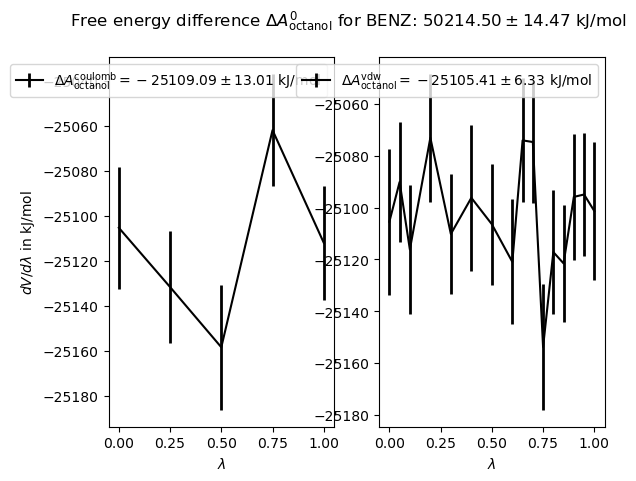

In [ ]:
goct.convert_edr()
goct.analyze_alchemlyb()

In [ ]:
plot_results(goct)

In [ ]:
delta_G, p_OW = mdpow.fep.pOW(gwat, goct)
print(f"log P_ow = {p_OW.value} ± {p_OW.error}")

mdpow.fep   : INFO     [BENZ] transfer free energy water --> octanol calculation
mdpow.fep   : INFO     The solvent is water .
mdpow.fep   : INFO     Using already calculated free energy DeltaA
mdpow.fep   : INFO     The solvent is octanol .
mdpow.fep   : INFO     Using already calculated free energy DeltaA
mdpow.fep   : INFO     [BENZ] Values at T = 300 K
mdpow.fep   : INFO     [BENZ] Free energy of transfer water --> octanol: -17812.254 (15.182) kJ/mol
mdpow.fep   : INFO     [BENZ] log P_ow: 3101.325 (2.643)


log P_ow = 3101.324683550301 ± 2.643399588149987
